In [1]:
import requests
import struct
import numpy as np
import io
import matplotlib.pyplot as plt
import pandas
import SciServer.CasJobs as cj
import urllib
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MultipleLocator
from multiprocessing.dummy import Pool as ThreadPool 
import multiprocessing
pandas.set_option('display.max_colwidth',200)

# some utility classes and functions

In [2]:
class Sphere():
    """
    Represents a spherical region. Can check for inclusion of a pointand serialize itself in the 
    format acecepted by the Spatial3D library's parser.
    """
    def __init__(self,x,y,z,r):
        self.x=x
        self.y=y
        self.z=z
        self.pos=[x,y,z]
        self.r=r
        self.r2=r*r
    
    def __str__(self):
        return "SPHERE[%f,%f,%f,%f]"%(self.x,self.y,self.z,self.r)
    
    def contained(self,pos,box):
        hbox=box/2
        a=np.abs(pos-self.pos)
        a[a>hbox]-=box
        d=np.sum(a**2,axis=1)
        return pos[np.where(d<=self.r2)]


In [6]:
class Gadget():
    """
    Class representing a Gadget simulation.
    Can read snapshot files from Millennium suite of simulations.
    """
    def __init__(self, shortName='mMR',box=62.5):
        self.shortName=shortName
        self.box=box
        
    @staticmethod
    def readHeader(file):
        header={}
        with open(file,"rb") as f:
            io = DataInputStream(f)

            if io.read_int() != 256:
                return None

            header['np']=io.read_ints(6)#np.frombuffer(io.stream,dtype=np.float32,count=6)
            header['mass']=io.read_doubles(6)
            header['time'],header['redshift']=io.read_doubles(2)
            header['flag_sfr'],header['flag_feedback']=io.read_ints(2)
            header['nptotal']=io.read_ints(6)
            header['flag_cooling'],header['num_files']=io.read_ints(2)
            header['BoxSize'],header['omega0'],header['omegaL'],header['hubble']=io.read_doubles(4)
            header['flag_stellarage'],header['flag_metals'],header['hashtabsize']=io.read_ints(3)
        return header
    
    def getParticles(self,file,shift,gr,shape):
        npart=sum(gr['ixcount'].values)
        nalloc=npart*3
        narr=np.zeros(nalloc,dtype=np.float32)
        count=0;ncount=0;
        # open file
        with open(file,"rb") as f:
            # for gr tuples step through file
            for g in gr.itertuples():
                ix=g[4]
                nb=g[5]
                n=int(nb/4)
                f.seek(ix)
                chunk=f.read(nb)
                narr[ncount:(ncount+n)]=np.frombuffer(chunk,dtype=np.float32,count=n)
                count+=1
                ncount+=n
        narr=narr.reshape(npart,3)
        return shape.contained(narr,self.box)+shift

    def retrieveParticles(self,df,shape):
        pos={}
        ntot=0
        for k,gr in df.groupby(['loc','shiftx','shifty','shiftz']):
            particles=self.getParticles(k[0],np.array(k[1:]),gr,shape)
            if particles is not None:
                pos[k]=particles
                ntot+=len(particles)
            else:
                print('No particles found in {0}'.format(k[0]))
        pos['NumParticles']=ntot
        return pos

    def mMRparticlesInShape(self,shape,snapnum=63):
        '''
        Calculate which millimil particles are contained in the shape.
        Does so by querying database for the Peano-Hilbert cell ranges and the files that contain them.
        Then accesses these files "efficiently" and finally checks whether shape actually contains the particles.
        '''
        sql="""
        select '/home/idies/workspace/virgo/'+substring(fr.[location],CHARINDEX('millimil',fr.[location]),100) as loc
            ,      min(mr.ixstart) as ixstart
            ,      sum(ixcount) as ixcount 
            ,      4+256+4+4+4*3*min(mr.ixstart) as ibstart
            ,      4*3*sum(ixcount) as ibcount 
              , fr.shiftx
              , fr.shifty
              , fr.shiftz
            from getFileRanges_mMR('mMR',{0},'{1}') fr
            left outer join mmrbins mr
            on mr.snapnum=fr.snapnum
            and mr.phkey between fr.keymin and fr.keymax
            group by fr.location, fr.shiftx, fr.shifty, fr.shiftz,fr.keymin,fr.keymax
            order by fr.location, fr.shiftx, fr.shifty, fr.shiftz,fr.keymin 
        """.format(snapnum,str(shape))
        _df=cj.executeQuery(sql,"SimulationDB")
        pos=self.retrieveParticles(_df,shape)
        return pos,_df

    def MRparticlesInShape(self,shape,snapnum=63):
        sql="""
        select '/home/idies/workspace/virgo/'+substring(fr.[location],CHARINDEX('Millennium',fr.[location]),100) as loc
            ,      min(mr.ixstart) as ixstart
            ,      sum(ixcount) as ixcount 
            ,      4+256+4+4+4*3*min(mr.ixstart) as ibstart
            ,      4*3*sum(ixcount) as ibcount 
              , fr.shiftx
              , fr.shifty
              , fr.shiftz
            from getFileRanges2('MR',{0},'{1}') fr
            left outer join mrbins mr
            on mr.snapnum=fr.snapnum
            and mr.phkey between fr.keymin and fr.keymax
            group by fr.location, fr.shiftx, fr.shifty, fr.shiftz,fr.keymin,fr.keymax
            order by fr.location, fr.shiftx, fr.shifty, fr.shiftz,fr.keymin 
        """.format(snapnum,str(shape))
        _df=cj.executeQuery(sql,"SimulationDB")
        pos=self.retrieveParticles(_df,shape)
        return pos,_df

    
gadget=Gadget()

In [4]:
# query for most massive millimil halos

gadget=Gadget('mMR',62.5)
sql="""
select top 10 haloid ,x,y,z,halfmassradius,np
from mpahalo
where snapnum=63 
and haloid=firsthaloinfofgroupid
order by np desc
"""
halos=cj.executeQuery(sql,"millimil")

halos.head(4)



,haloid,x,y,z,halfmassradius,np
0,3000042000000,43.98392,14.84231,13.72004,0.410264,137272
1,2000020000000,34.39621,59.45672,29.85688,0.410727,119152
2,1000019001111,31.62164,55.37667,27.84001,0.561269,102091
3,4000014000000,58.81298,13.09029,33.35340,0.396741,87950


In [8]:
# query for most massive millimil halos

gadget=Gadget('MR',500)
sql="""
select top 10 haloid ,x,y,z,halfmassradius,np
from mr
where snapnum=63 
and haloid=firsthaloinfofgroupid
order by np desc
"""
halos=cj.executeQuery(sql,"mpahalotrees")

halos.head(4)


,haloid,x,y,z,halfmassradius,np
0,140005829198416,319.32770,417.7765,158.5383,1.222774,3338045
1,448000101042143,29.63057,212.3603,447.5762,1.174539,2744859
2,388000049000000,228.60990,341.6779,399.4931,0.996062,1821364
3,140005829017979,331.81810,412.3622,133.3231,0.975727,1592926


CPU times: user 793 ms, sys: 501 ms, total: 1.29 s
Wall time: 3.9 s
CPU times: user 889 ms, sys: 531 ms, total: 1.42 s
Wall time: 2.95 s
CPU times: user 400 ms, sys: 92.2 ms, total: 492 ms
Wall time: 1.97 s
CPU times: user 336 ms, sys: 151 ms, total: 487 ms
Wall time: 1.66 s
CPU times: user 7.6 s, sys: 1.62 s, total: 9.22 s
Wall time: 16 s


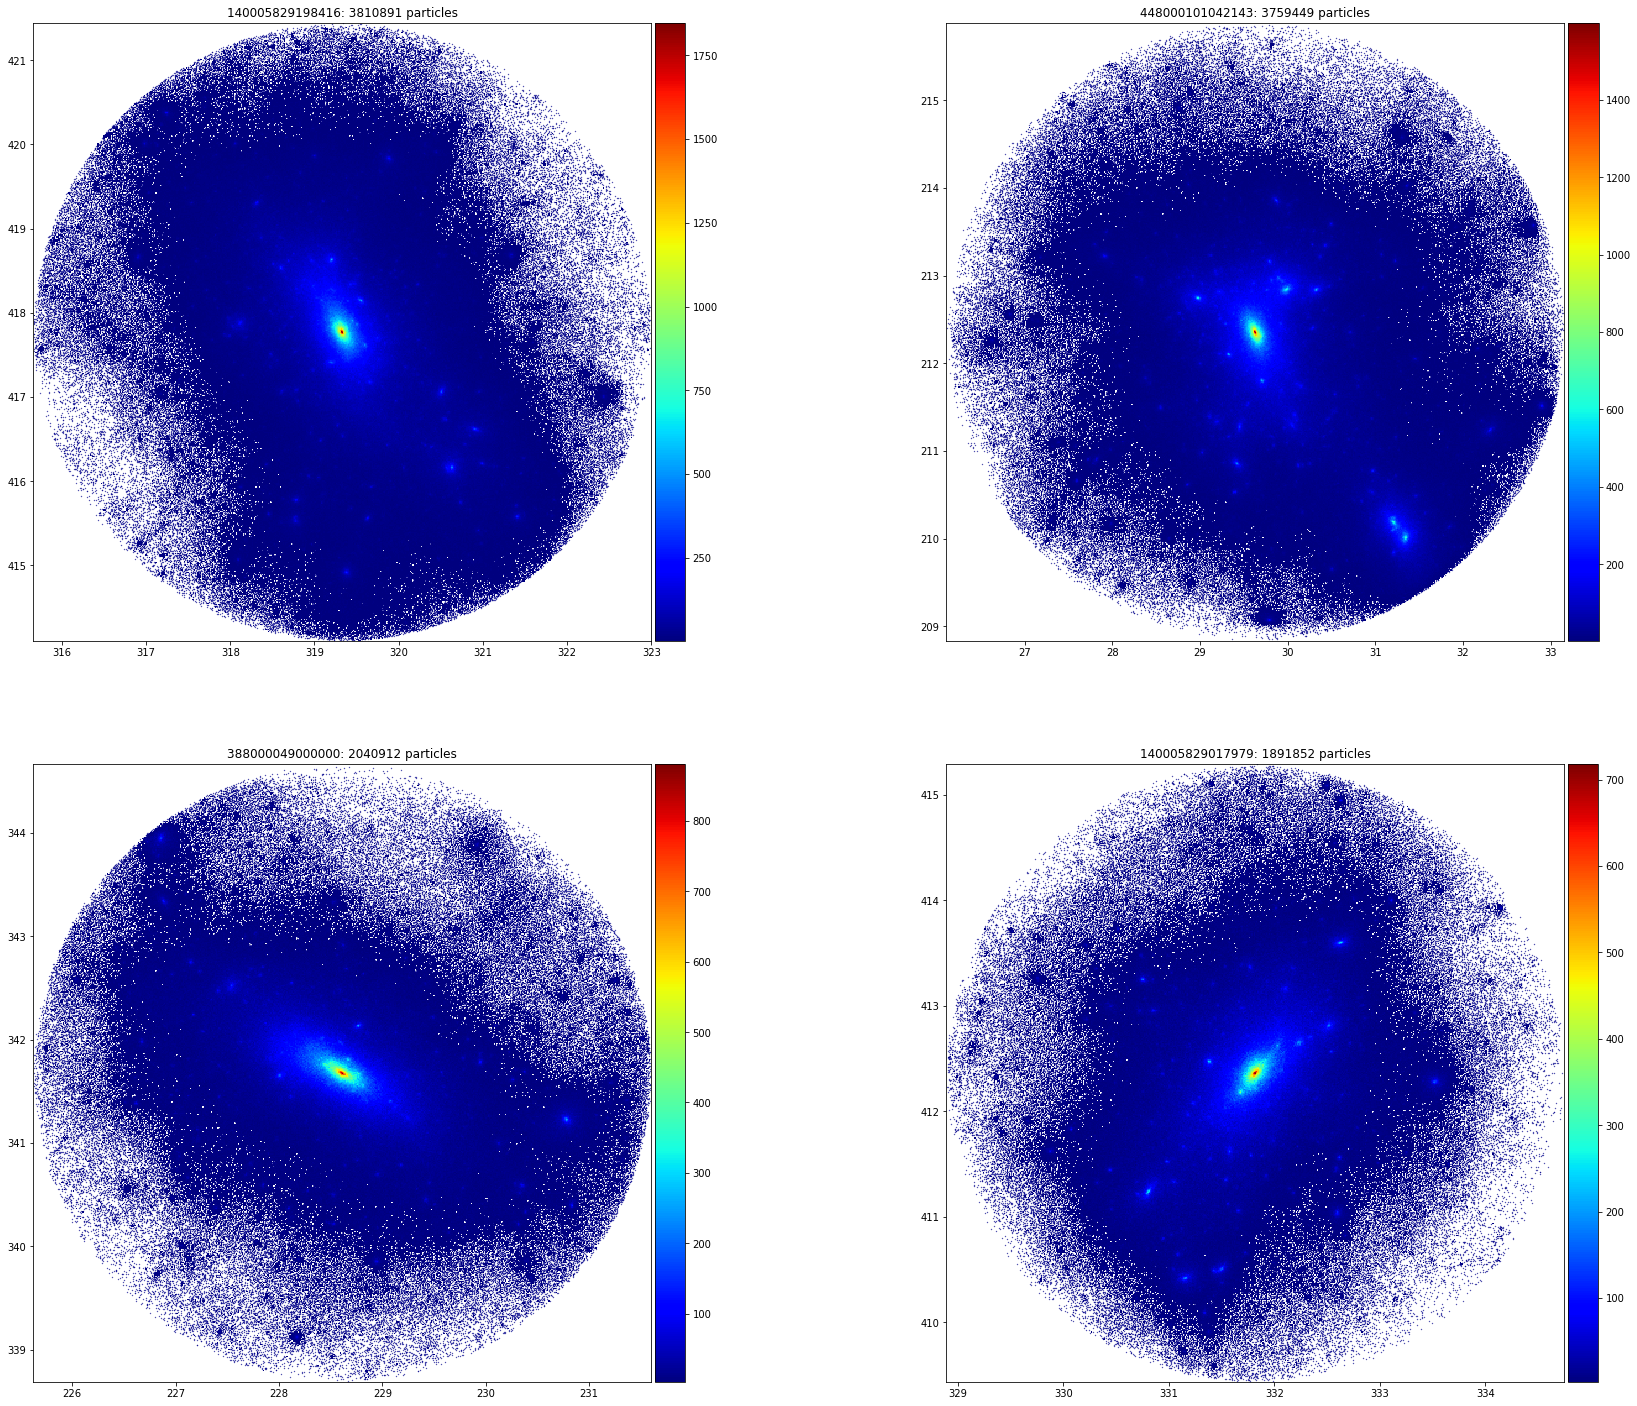

In [10]:
%%time
fig, axes = plt.subplots(2,2)
fig.set_size_inches(30, 25, forward=True)
axes=np.ravel(axes)


i=0
for key,row in halos.head(4).iterrows():
    shape=Sphere(row.x,row.y,row.z,3*row.halfmassradius)
    if gadget.shortName == 'mMR':
        %time p,df=gadget.mMRparticlesInShape(shape)
    elif gadget.shortName == 'MR':
        %time p,df=gadget.MRparticlesInShape(shape)
    title="%d: %d particles"%(row.haloid,p['NumParticles'])


    #histogram definition
    xdat=np.zeros(p['NumParticles'])
    ydat=np.zeros(p['NumParticles'])

    count=0
    for k in p.keys():
        if k=='NumParticles':
            continue
        xdat[count:(count+len(p[k]))]=p[k][:,0]
        ydat[count:(count+len(p[k]))]=p[k][:,1];
        count+=len(p[k])

    xyrange=[[shape.x-shape.r,shape.x+shape.r],[shape.y-shape.r,shape.y+shape.r]]
    bins = [500,500] # number of bins
    thresh = 3  #density threshold

    hh, locx, locy = np.histogram2d(xdat, ydat, range=xyrange, bins=bins)
    posx = np.digitize(xdat, locx)
    posy = np.digitize(ydat, locy)

    #select points within the histogram
    ind = (posx > 0) & (posx <= bins[0]) & (posy > 0) & (posy <= bins[1])
    hhsub = hh[posx[ind] - 1, posy[ind] - 1] # values of the histogram where the points are
    xdat1 = xdat[ind][hhsub < thresh] # low density points
    ydat1 = ydat[ind][hhsub < thresh]
    hh[hh < thresh] = np.nan # fill the areas with low density by NaNs

    ax=axes[i]
    ax.set_aspect('equal')
    i+=1

    im=ax.imshow(np.flipud(hh.T),cmap='jet',extent=np.array(xyrange).flatten(), interpolation='none', origin='upper')
    ax.scatter(xdat1, ydat1, s=.1,color='darkblue');
    ax.set_title(title)
    divider = make_axes_locatable(ax)
    # Append axes to the right of ax3, with 20% width of ax3
    cax = divider.append_axes("right", size="5%", pad=0.05)
    # Create colorbar in the appended axes
    # Tick locations can be set with the kwarg `ticks`
    # and the format of the ticklabels with kwarg `format`
    cbar = plt.colorbar(im, cax=cax)#, ticks=MultipleLocator(0.2), format="%.2f")